In [ ]:
# Installing category_encoders for TargetEncoder
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Reading csv file
data = pd.read_csv(r'H2HBABBA2697.csv')
data.shape


(50000, 19)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

In [ ]:
data.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    4
isOpen                        0
dtype: int64

In [ ]:
# testing_data is the final data in which model has to predict
testing_data = data[data['clear_date'].isnull()].copy()
print(testing_data['clear_date'].isnull().sum())

10000


In [ ]:
training_data = data[data['clear_date'].notnull()].copy()
print(training_data['clear_date'].notnull().sum())

40000


In [ ]:
# Removed any column which has all the value 

training_data.dropna(how='all', inplace=True, axis=1)
training_data.shape

(40000, 18)

In [ ]:
# convert the data type of the date column to DateTime

training_data['clear_date'] = pd.to_datetime(training_data['clear_date'])
training_data['posting_date'] = pd.to_datetime(training_data['posting_date'])
training_data['due_in_date'] = pd.to_datetime(training_data['due_in_date'], format='%Y%m%d')
training_data['baseline_create_date'] = pd.to_datetime(training_data['baseline_create_date'], format='%Y%m%d')
training_data['document_create_date.1'] = pd.to_datetime(training_data['document_create_date.1'], format='%Y%m%d')
training_data['document_create_date'] = pd.to_datetime(training_data['document_create_date'], format='%Y%m%d')

In [ ]:
training_data.dtypes

business_code                     object
cust_number                       object
name_customer                     object
clear_date                datetime64[ns]
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
document_create_date      datetime64[ns]
document_create_date.1    datetime64[ns]
due_in_date               datetime64[ns]
invoice_currency                  object
document type                     object
posting_id                       float64
total_open_amount                float64
baseline_create_date      datetime64[ns]
cust_payment_terms                object
invoice_id                       float64
isOpen                             int64
dtype: object

In [ ]:
# List of columns with constant features

constant_features = [feat for feat in training_data.columns if training_data[feat].dtype not in [object, '<M8[ns]'] and training_data[feat].std() == 0]
constant_features

['posting_id', 'isOpen']

In [ ]:
def findDuplicateColumns(data):
    """
    Function to find all duplicate columns
    """
    duplicate_columns = set()
    for i in range(data.shape[1]):
        col1 = data.iloc[:, i]
        for j in range(i+1, data.shape[1]):
            col2 = data.iloc[:, j]
            if col1.equals(col2):
                duplicate_columns.add(data.columns.values[j])
        
    return list(duplicate_columns)

duplicate_columns = findDuplicateColumns(training_data)
duplicate_columns

[]

In [ ]:
# Unique value in each column and their counts
for feat in training_data.columns:
    print(f'{feat}\n {training_data[feat].value_counts()}')
    print('\n\n')


business_code
 U001    36117
CA02     3203
U013      535
U002      134
U005        9
U007        2
Name: business_code, dtype: int64



cust_number
 0200769623    9056
0200726979    1461
0200762301    1194
0200759878    1072
0200794332     852
              ... 
0100047799       1
0200585100       1
200744707        1
0200389625       1
100053653        1
Name: cust_number, Length: 1325, dtype: int64



name_customer
 WAL-MAR systems        923
WAL-MAR corporation    919
WAL-MAR trust          906
WAL-MAR                900
WAL-MAR llc            897
                      ... 
HIGHLAN foundation       1
SHEET trust              1
SUPERV trust             1
EB llc                   1
ASTR in                  1
Name: name_customer, Length: 3924, dtype: int64



clear_date
 2019-09-03    287
2019-10-15    264
2019-11-18    256
2019-11-01    255
2019-07-08    250
             ... 
2020-05-12      1
2020-05-19      1
2019-08-17      1
2019-05-18      1
2019-06-22      1
Name: clear_date, Le

In [ ]:
# Combining ['U013','U002','U005','U007'] in one group as they are having less frequency
training_data['business_code']=np.where(training_data['business_code'].isin(['U013','U002','U005','U007']),'other_business_code',training_data['business_code'])

In [ ]:
# Checking for common values
print(list(training_data['document_create_date.1'] == training_data['baseline_create_date']).count(True))
print(list(training_data['document_create_date.1'] == training_data['posting_date']).count(True))
print(list(training_data['document_create_date'] == training_data['document_create_date.1']).count(True))
print(list(training_data['document_create_date'] == training_data['posting_date']).count(True))
print(list(training_data['baseline_create_date'] == training_data['posting_date']).count(True))

35541
39996
17043
17047
35537


In [ ]:
training_data.nunique()

business_code                 3
cust_number                1325
name_customer              3924
clear_date                  401
buisness_year                 2
doc_id                    39141
posting_date                423
document_create_date        425
document_create_date.1      424
due_in_date                 485
invoice_currency              2
document type                 2
posting_id                    1
total_open_amount         35609
baseline_create_date        432
cust_payment_terms           71
invoice_id                39137
isOpen                        1
dtype: int64

In [ ]:
# Dropping these columns to prevent overfitting

cols_to_remove = set(duplicate_columns + ['document_create_date.1', 'doc_id', 'invoice_id', 'posting_id', 'document type'] + constant_features)
training_data.drop(inplace=True, axis=1, columns=cols_to_remove)
training_data.shape

(40000, 12)

In [ ]:
print(training_data.duplicated().sum())
training_data.shape

864


(40000, 12)

In [ ]:
# Removed duplicate rows

training_data.drop_duplicates(keep='first', inplace=True)
training_data.shape

(39136, 12)

In [ ]:
# Sorting DF with respect to feature posting_date to train model on old data

training_data.sort_values(by=['posting_date'], inplace=True)
training_data.reset_index(drop=True, inplace=True)


In [ ]:
# Spliting datetime features to year, mont and quarter

for feature in ['posting_date', 'due_in_date', 'baseline_create_date', 'document_create_date']:
    training_data[feature+'_year'] = training_data[feature].dt.year
    training_data[feature+'_month'] = training_data[feature].dt.month
    training_data[feature+'_quarter'] = training_data[feature].dt.quarter


In [ ]:
# Creating target column
training_data['delay'] = training_data.loc[:, 'clear_date'] - training_data.loc[:, 'due_in_date']
training_data['delay'] = training_data['delay'].astype('timedelta64[D]').astype(int)

# Delta_due_post: Difference between due_in_date and posting_date
training_data['Delta_due_post'] = training_data.loc[: , 'due_in_date']-training_data.loc[:,'posting_date']
training_data['Delta_due_post'] = training_data['Delta_due_post'].astype('timedelta64[D]').astype(int)

In [ ]:
# Deleting datetime column as now they are redundant after spliting them into their sub features
training_data.drop(inplace=True, columns=['clear_date', 'posting_date', 'due_in_date','baseline_create_date', 'document_create_date'], axis=1)

## Spliting Training data

In [ ]:
X = training_data.drop(['delay'], axis=1)
Y = training_data['delay']

In [ ]:
# Spliting training data into train, test and validation set

X_train, X_test_set, Y_train, Y_test_set = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=0)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test_set, Y_test_set, test_size=0.5, shuffle=False, random_state=0)

In [ ]:
def drop_features(features):
    """
    Function to drop columns from train, test and validation sets
    """
    X_train.drop(inplace=True, axis=1, columns=features)
    X_validation.drop(inplace=True, axis=1, columns=features)
    X_test.drop(inplace=True, axis=1, columns=features)


## EDA

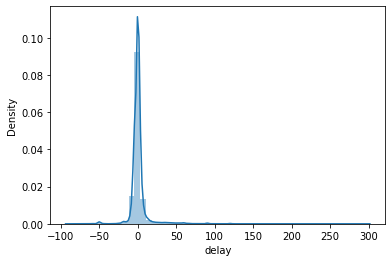

In [ ]:
# Below graph is right skewed
sns.distplot(Y_train)

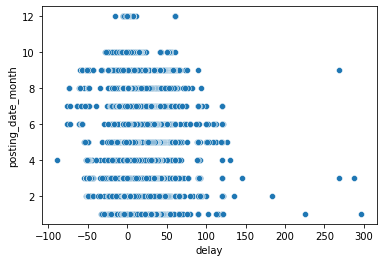

In [ ]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='posting_date_month')

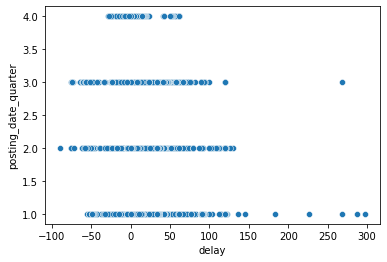

In [ ]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='posting_date_quarter')

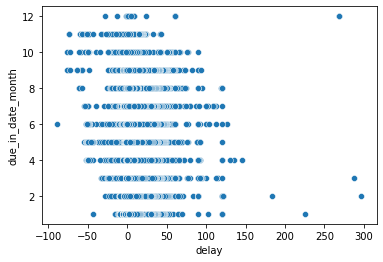

In [ ]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='due_in_date_month')

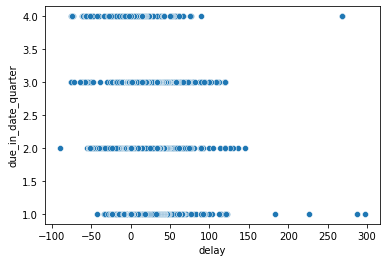

In [ ]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='due_in_date_quarter')

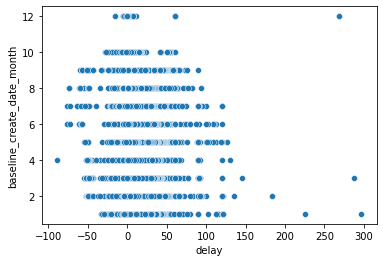

In [ ]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='baseline_create_date_month')

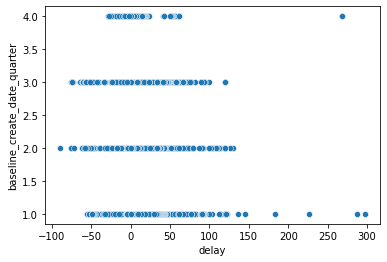

In [ ]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='baseline_create_date_quarter')

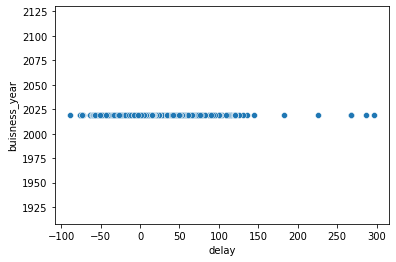

In [ ]:
# Constant Feature
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='buisness_year')

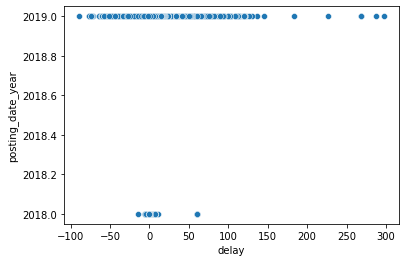

In [ ]:
# Constant Feature
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='posting_date_year')

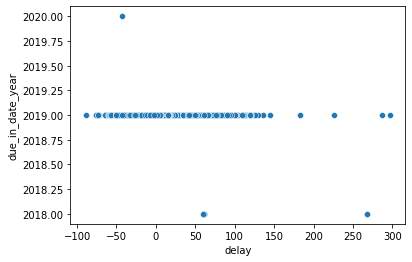

In [ ]:
# Constant Feature
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='due_in_date_year')

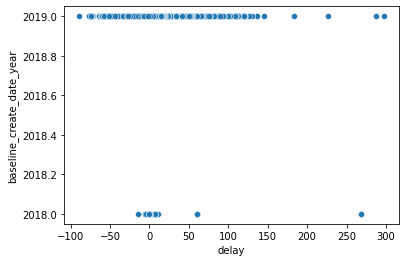

In [ ]:
# Constant Feature
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='baseline_create_date_year')

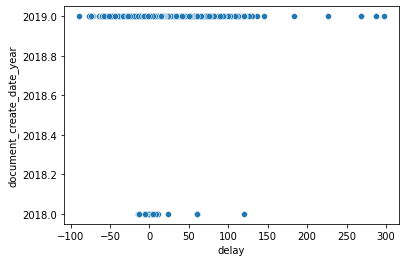

In [ ]:
# Constant Feature
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="delay", y='document_create_date_year')

## Feature engineering

In [ ]:
feature_to_encode = [col for col in training_data.columns if col != 'invoice_currency' and training_data[col].dtype == object]
feature_to_encode

['business_code', 'cust_number', 'name_customer', 'cust_payment_terms']

In [ ]:
# Using target encoding to encode categorical features

target_encoder = TargetEncoder(cols=feature_to_encode)
X_train = target_encoder.fit_transform(X_train, Y_train)
X_validation = target_encoder.transform(X_validation)
X_test = target_encoder.transform(X_test)

In [ ]:
# Using label elcoding for invoice_currency as it has only 2 unique features

label_encoder = LabelEncoder()
X_train['invoice_currency'] = label_encoder.fit_transform(X_train['invoice_currency'])
X_validation['invoice_currency'] = label_encoder.transform(X_validation['invoice_currency'])
X_test['invoice_currency'] = label_encoder.transform(X_test['invoice_currency'])

In [ ]:
X_train.shape, X_validation.shape, X_test.shape

((27395, 20), (5870, 20), (5871, 20))

## Feature selection

In [ ]:
# Removing quasi constant features

sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(X_train)
len(X_train.columns[sel.get_support()])
quasi_constants = [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]
drop_features(quasi_constants) # droping features
quasi_constants

['buisness_year',
 'posting_date_year',
 'due_in_date_year',
 'baseline_create_date_year',
 'document_create_date_year']

In [ ]:
Q1 = X_train.quantile(.25)
Q3 = X_train.quantile(.75)
IQR = Q3 - Q1

In [ ]:
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

In [ ]:
for col in X_train.columns:
    print(X_train[col].value_counts().sum(), col)

27395 business_code
27395 cust_number
27395 name_customer
27395 invoice_currency
27395 total_open_amount
27395 cust_payment_terms
27395 posting_date_month
27395 posting_date_quarter
27395 due_in_date_month
27395 due_in_date_quarter
27395 baseline_create_date_month
27395 baseline_create_date_quarter
27395 document_create_date_month
27395 document_create_date_quarter
27395 Delta_due_post


In [ ]:
# features with outliers and their counts
print(((X_train < lower_bound) | (X_train > upper_bound)).sum())

business_code                   2733
cust_number                     2017
name_customer                   2284
invoice_currency                2227
total_open_amount               1430
cust_payment_terms              5055
posting_date_month                 0
posting_date_quarter               0
due_in_date_month                  0
due_in_date_quarter                0
baseline_create_date_month         0
baseline_create_date_quarter       0
document_create_date_month         0
document_create_date_quarter       0
Delta_due_post                  7256
dtype: int64


2.820901518832487
#################################


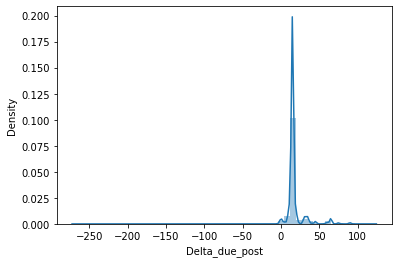

In [ ]:
print(X_train['Delta_due_post'].skew())
print('#################################')
sns.distplot(X_train.Delta_due_post)

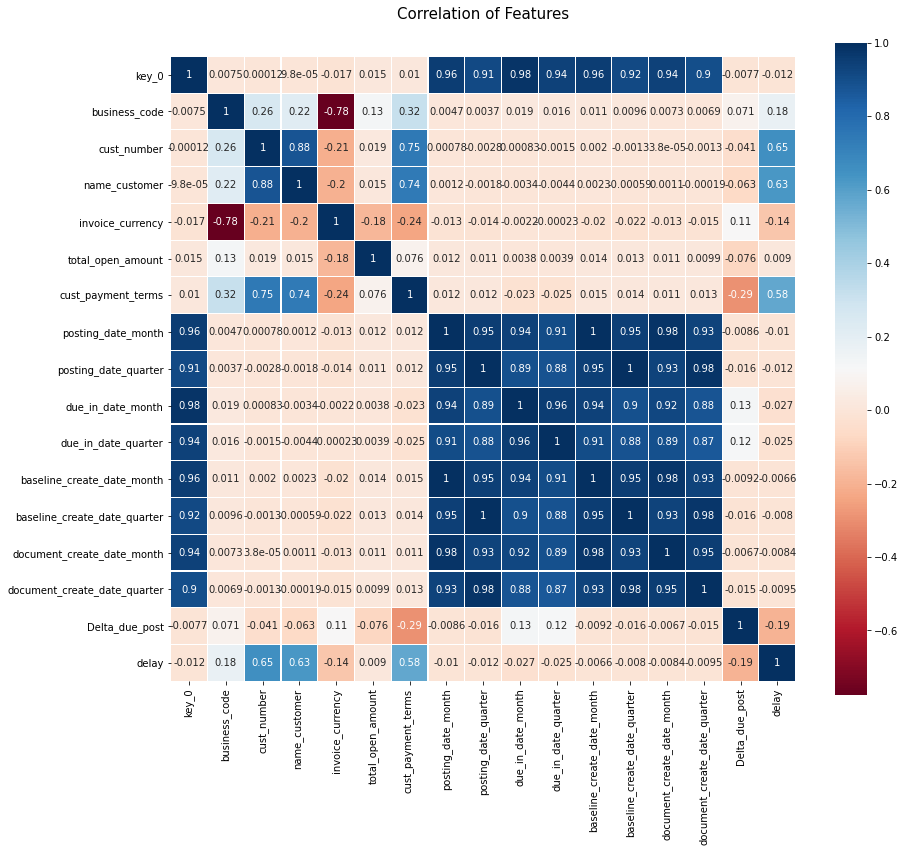

In [ ]:
# Generating heat map

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.merge(Y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
# Removing features with high corelation
drop_features(['posting_date_month', 'posting_date_month', 'due_in_date_month', 'document_create_date_quarter', 'document_create_date_month', 'baseline_create_date_month', 'baseline_create_date_quarter'])

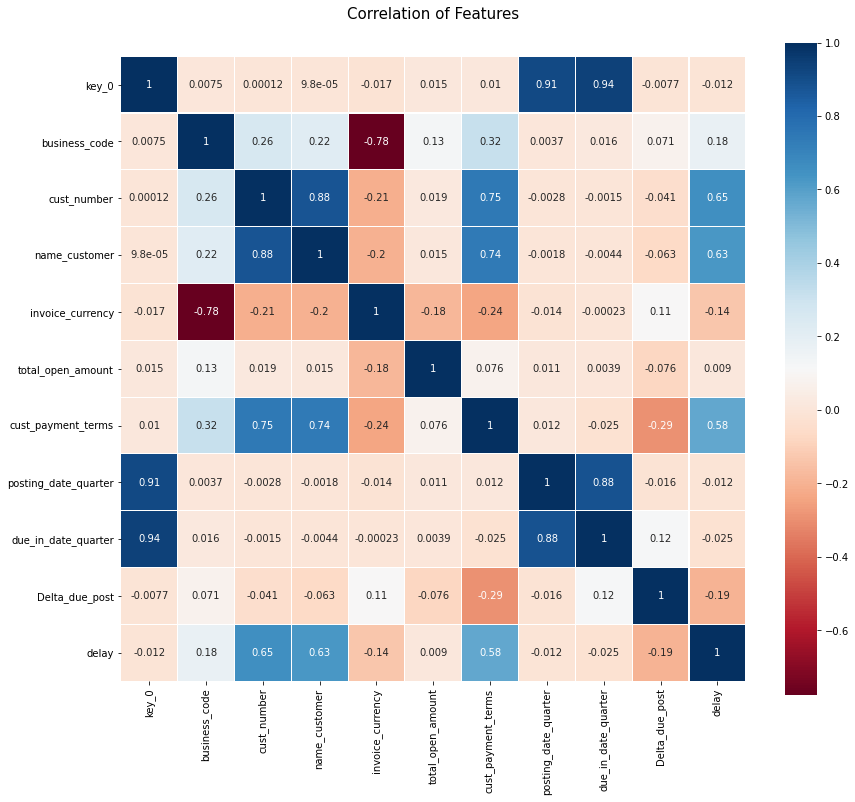

In [ ]:
# Generating heat map

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.merge(Y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Feature scaling

In [ ]:
# Performing normalization of data

normalization_scaler = StandardScaler() 
X_train_normalized = normalization_scaler.fit_transform(X_train) 
X_test_normalized = normalization_scaler.transform(X_test) 
X_validation_normalized = normalization_scaler.transform(X_validation)

## Modelling

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
# Defining Lists to Store in the Results and Names of Algorithms
RMSE_Score_validation = []
RMSE_Score_test = []
R2_Score_validation = []
R2_Score_test = []
Algorithm = []

### **1. Linear Regression**

In [ ]:
Algorithm.append('Linear Regression')
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_normalized, Y_train)

# Predicting the Test and Validation Set Result
predicted_val_set = linear_regressor.predict(X_validation_normalized)
predicted_test_set = linear_regressor.predict(X_test_normalized)

In [ ]:
# Appending the Scores For Visualisation at a Later Part
RMSE_Score_validation.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_validation.append(r2_score(Y_validation, predicted_val_set))
RMSE_Score_test.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_test.append(r2_score(Y_test, predicted_test_set))

### **2. Support Vector Regression**

In [ ]:
# Fitting SVR to the Training Set
Algorithm.append('Support Vector Regression')
svr = SVR()
svr.fit(X_train_normalized, Y_train)

# Predicting the Test and Validation Set Result
predicted_val_set = svr.predict(X_validation_normalized)
predicted_test_set = svr.predict(X_test_normalized)

In [ ]:
# Appending the Scores For Visualisation at a Later Part
RMSE_Score_validation.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_validation.append(r2_score(Y_validation, predicted_val_set))
RMSE_Score_test.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_test.append(r2_score(Y_test, predicted_test_set))

### **3. Decision Tree Regressor**

In [ ]:
# Fitting Decision Tree to the Training Set
Algorithm.append('Decision Tree Regressor')
decision_tree_regressor = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

decision_tree_regressor.fit(X_train_normalized, Y_train)

# Predicting the Test and Validation Set Result
predicted_val_set = decision_tree_regressor.predict(X_validation_normalized)
predicted_test_set = decision_tree_regressor.predict(X_test_normalized)

In [ ]:
# Appending the Scores For Visualisation at a Later Part
RMSE_Score_validation.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_validation.append(r2_score(Y_validation, predicted_val_set))
RMSE_Score_test.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_test.append(r2_score(Y_test, predicted_test_set))

### **4. Random Forest Regressor**

In [ ]:
# Fitting Random Forest Regressor Tree to the Training Set
Algorithm.append('Random Forest Regressor')
random_forest = RandomForestRegressor()
random_forest.fit(X_train_normalized, Y_train)

# Predicting the Test and Validation Set Result
predicted_val_set = random_forest.predict(X_validation_normalized)
predicted_test_set = random_forest.predict(X_test_normalized)

In [ ]:
# Appending the Scores For Visualisation at a Later Part
RMSE_Score_validation.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_validation.append(r2_score(Y_validation, predicted_val_set))
RMSE_Score_test.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_test.append(r2_score(Y_test, predicted_test_set))

### **5. XGB Regressor**

In [ ]:
# Fitting XGBoost Regressor to the Training Set
Algorithm.append('XGB Regressor')
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train_normalized, Y_train)

# Predicting the Test and Validation Set Result
predicted_val_set = xgb_regressor.predict(X_validation_normalized)
predicted_test_set = xgb_regressor.predict(X_test_normalized)

[22:54:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Appending the Scores For Visualisation at a Later Part
RMSE_Score_validation.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_validation.append(r2_score(Y_validation, predicted_val_set))
RMSE_Score_test.append(mean_squared_error(Y_test, predicted_test_set, squared=False))
R2_Score_test.append(r2_score(Y_test, predicted_test_set))

## Score Card of the Models' Performances

In [ ]:
# Just Combining the Lists into a DataFrame for a Better Visualisation
Comparison = pd.DataFrame(list(zip(Algorithm, RMSE_Score_validation, R2_Score_validation, RMSE_Score_test, R2_Score_test)), columns = ['Algorithm', 'RMSE_Score_validation', 'R2_Score_validation', 'RMSE_Score_test', 'R2_Score_test'])

In [ ]:
# Score card
Comparison

,Algorithm,RMSE_Score_validation,R2_Score_validation,RMSE_Score_test,R2_Score_test
0,Linear Regression,7.712114,0.412052,7.712114,0.422977
1,Support Vector Regression,7.735943,0.492233,7.735943,0.419406
2,Decision Tree Regressor,7.666381,0.390824,7.666381,0.429800
3,Random Forest Regressor,7.932062,0.212379,7.932062,0.389595
4,XGB Regressor,7.421316,0.454025,7.421316,0.465672


### According to table Decision Tree Regressor has best accuricy



## Predict dates


In [ ]:
testing_data.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             10000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    0
isOpen                        0
dtype: int64

In [ ]:
# Droping Null columns

X_testing_data = testing_data.drop(columns=['clear_date', 'area_business'], axis=1)
testing_data.drop(['clear_date', 'area_business'], axis=1, inplace=True)
X_testing_data.shape

(10000, 17)

In [ ]:
X_testing_data.nunique()

business_code                5
cust_number                661
name_customer             1724
buisness_year                1
doc_id                    9714
posting_date                82
document_create_date        88
document_create_date.1      82
due_in_date                126
invoice_currency             2
document type                1
posting_id                   1
total_open_amount         9102
baseline_create_date        85
cust_payment_terms          40
invoice_id                9714
isOpen                       1
dtype: int64

In [ ]:
# convert the data type of the date column to DateTime

X_testing_data['posting_date'] = pd.to_datetime(X_testing_data['posting_date'])
X_testing_data['due_in_date'] = pd.to_datetime(X_testing_data['due_in_date'], format='%Y%m%d')
X_testing_data['baseline_create_date'] = pd.to_datetime(X_testing_data['baseline_create_date'], format='%Y%m%d')
X_testing_data['document_create_date.1'] = pd.to_datetime(X_testing_data['document_create_date.1'], format='%Y%m%d')
X_testing_data['document_create_date'] = pd.to_datetime(X_testing_data['document_create_date'], format='%Y%m%d')

In [ ]:
# Combining ['U013','U002','U005','U007'] in one group as they are having less frequency
X_testing_data['business_code']=np.where(X_testing_data['business_code'].isin(['U013','U002','U005','U007']),'other_business_code',X_testing_data['business_code'])

In [ ]:
# Droping Features

cols_to_remove = set(duplicate_columns + ['document_create_date.1', 'doc_id', 'invoice_id', 'posting_id', 'document type'] + constant_features)
X_testing_data.drop(inplace=True, axis=1, columns=cols_to_remove)


In [ ]:
# Sorting DF with respect to feature posting_date to train model on old data

X_testing_data.sort_values(by=['posting_date'], inplace=True)
X_testing_data.reset_index(drop=True, inplace=True)

In [ ]:
# Spliting datetime features to year, month and quarter

for feature in ['posting_date', 'due_in_date', 'baseline_create_date', 'document_create_date']:
    X_testing_data[feature+'_year'] = X_testing_data[feature].dt.year
    X_testing_data[feature+'_month'] = X_testing_data[feature].dt.month
    X_testing_data[feature+'_quarter'] = X_testing_data[feature].dt.quarter

In [ ]:
X_testing_data['Delta_due_post'] = X_testing_data.loc[: , 'due_in_date']-X_testing_data.loc[:,'posting_date']
X_testing_data['Delta_due_post'] = X_testing_data['Delta_due_post'].astype('timedelta64[D]').astype(int)


In [ ]:
X_testing_data.drop(inplace=True, columns=['posting_date', 'due_in_date','baseline_create_date', 'document_create_date'], axis=1)

In [ ]:
X_train.shape, X_testing_data.shape, X_test.shape

((27395, 9), (10000, 20), (5871, 9))

In [ ]:
# Transforming categorical features in final testing set using target encoder
X_testing_data = target_encoder.transform(X_testing_data)

In [ ]:
# Transforming invoice_currency final testing set using label encoder
X_testing_data['invoice_currency'] = label_encoder.transform(X_testing_data['invoice_currency'])
X_testing_data

,business_code,cust_number,name_customer,buisness_year,invoice_currency,total_open_amount,cust_payment_terms,posting_date_year,posting_date_month,posting_date_quarter,due_in_date_year,due_in_date_month,due_in_date_quarter,baseline_create_date_year,baseline_create_date_month,baseline_create_date_quarter,document_create_date_year,document_create_date_month,document_create_date_quarter,Delta_due_post
0,0.343362,-0.080071,0.581395,2020.0,1,44906.11,0.451258,2020,2,1,2020,3,1,2020,2,1,2020,2,1,15
1,0.343362,0.736842,0.538465,2020.0,1,5868.64,-13.043643,2020,2,1,2020,5,2,2020,2,1,2020,2,1,65
2,6.487203,5.152381,3.160868,2020.0,0,834.00,6.603241,2020,2,1,2020,3,1,2020,2,1,2020,2,1,11
3,0.343362,-6.698529,-5.767442,2020.0,1,13413.89,-4.393204,2020,2,1,2020,3,1,2020,2,1,2020,2,1,32
4,0.343362,0.405263,-0.465116,2020.0,1,63885.28,1.243551,2020,2,1,2020,3,1,2020,2,1,2020,2,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.343362,1.000000,1.006548,2020.0,1,27984.87,1.243551,2020,5,2,2020,6,2,2020,5,2,2020,5,2,15
9996,0.343362,1.000001,0.709303,2020.0,1,17544.11,1.243551,2020,5,2,2020,6,2,2020,5,2,2020,5,2,15
9997,0.343362,4.121212,2.571660,2020.0,1,20.95,11.156098,2020,5,2,2020,6,2,2020,5,2,2020,5,2,30
9998,0.343362,4.121212,3.152328,2020.0,1,1.17,11.156098,2020,5,2,2020,6,2,2020,5,2,2020,5,2,30


In [ ]:
# droping quasi constants 
X_testing_data.drop(columns=quasi_constants, inplace=True)

In [ ]:
# Droping features with high correlation
X_testing_data.drop(columns=['posting_date_month', 'posting_date_month', 'due_in_date_month', 'document_create_date_quarter', 'document_create_date_month', 'baseline_create_date_month', 'baseline_create_date_quarter'], inplace=True)

In [ ]:
# Normalizing the data in final testing set
X_testing_data = normalization_scaler.transform(X_testing_data)

In [ ]:
# predicting the delay using the trained model
# delay2 = decision_tree_regressor.predict(X_testing_data)
# delay3 = svr.predict(X_testing_data)
predictions = xgb_regressor.predict(X_testing_data)

In [ ]:
delay = pd.DataFrame(pd.to_timedelta(predictions, unit='D'), columns=['delay'])
delay['delay'] = delay['delay'].dt.round('d')
bucket = []
for time in predictions:

    nearest_multimple = 15 * round(time / 15)
    if time < 0 or nearest_multimple == 0:
        bucket += '0-15',

    elif time <= nearest_multimple:
        bucket += f'{nearest_multimple-15}-{nearest_multimple}',
    
    else:
        bucket += f'{nearest_multimple+1}-{nearest_multimple+15}',

delay['Bucket'] = bucket
delay

,delay,Bucket
0,0 days,0-15
1,-2 days,0-15
2,5 days,0-15
3,-10 days,0-15
4,0 days,0-15
...,...,...
9995,1 days,0-15
9996,1 days,0-15
9997,5 days,0-15
9998,7 days,0-15


In [ ]:
testing_data.reset_index(drop=True,inplace=True)
testing_data['clear_data'] = pd.to_datetime(testing_data['due_in_date'], format='%Y%m%d') + delay['delay']
final = testing_data.merge(delay , on = testing_data.index).drop(columns=['key_0'])
final

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,clear_data,delay,Bucket
0,CA02,0140106347,F J W foundation,2020.0,2.960625e+09,2020-03-29,20200329,20200329,20200415.0,CAD,RV,1.0,15395.49,20200405.0,CA10,2.960625e+09,1,2020-04-15,0 days,0-15
1,U001,0200936373,SUPE trust,2020.0,1.930704e+09,2020-03-25,20200325,20200325,20200409.0,USD,RV,1.0,39025.63,20200325.0,NAA8,1.930704e+09,1,2020-04-07,-2 days,0-15
2,U001,0200794332,COST foundation,2020.0,1.930646e+09,2020-03-15,20200312,20200315,20200330.0,USD,RV,1.0,7071.83,20200315.0,NAAX,1.930646e+09,1,2020-04-04,5 days,0-15
3,U001,0200769623,WAL-MAR us,2020.0,1.930801e+09,2020-04-19,20200419,20200419,20200504.0,USD,RV,1.0,11447.55,20200419.0,NAH4,1.930801e+09,1,2020-04-24,-10 days,0-15
4,U001,0200706844,WINC in,2020.0,1.930689e+09,2020-03-23,20200323,20200323,20200407.0,USD,RV,1.0,50073.85,20200323.0,NAA8,1.930689e+09,1,2020-04-07,0 days,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,U001,0200704045,RA foundation,2020.0,1.930649e+09,2020-03-13,20200313,20200313,20200328.0,USD,RV,1.0,27572.55,20200313.0,NAA8,1.930649e+09,1,2020-03-29,1 days,0-15
9996,U001,0200794332,COST llc,2020.0,1.930624e+09,2020-03-05,20200309,20200305,20200320.0,USD,RV,1.0,45998.41,20200305.0,NAAX,1.930624e+09,1,2020-03-21,1 days,0-15
9997,U001,0200769623,WAL-MAR systems,2020.0,1.930768e+09,2020-04-09,20200409,20200409,20200424.0,USD,RV,1.0,43723.69,20200409.0,NAH4,1.930768e+09,1,2020-04-29,5 days,0-15
9998,U001,0200769623,WAL-MAR llc,2020.0,1.930619e+09,2020-03-08,20200307,20200308,20200323.0,USD,RV,1.0,71.11,20200308.0,NAH4,1.930619e+09,1,2020-03-30,7 days,0-15
